<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/baseline/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline algorithm
In this notebook we propose a training free approach that combines CLIP zero-shot with a YOLO architecture. This method involves extracting
all the bounding boxes proposed by YOLO and evaluating their similarity with the textual query with CLIP.

## Initialization

In [ ]:
!pip install jaxtyping

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
from pathlib import Path
import json
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List, Literal, Callable, TypedDict
from jaxtyping import Array, Float, UInt
import pickle
import itertools as it
import re
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from pkg_resources import packaging
import clip
import numpy as np

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Download the dataset.
**TODO:** prima di scaricare il dataset controllare che non esista già.

In [ ]:
!mkdir dataset
!gdown 1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb
!mv refcocog.tar.gz ./dataset/
!tar -xf dataset/refcocog.tar.gz -C dataset
!rm dataset/refcocog.tar.gz

Folder paths

In [ ]:
data = Path("dataset/refcocog/") #main dataset folder
data_instances = Path("dataset/refcocog/annotations/instances.json")  #instances.json
data_refs = Path("dataset/refcocog/annotations/refs(umd).p")  #refs(umd).p
data_images = Path("dataset/refcocog/images") #image folder

Type declaration

In [ ]:
Split = Literal['train', 'test', 'val']


class Info(TypedDict, total=True):
    description: str  # This is stable 1.0 version of the 2014 MS COCO dataset.
    url: str  # http://mscoco.org/
    version: str  # 1.0
    year: int  # 2014
    contributor: str  # Microsoft COCO group
    data_created: str  # 2015-01-27 09:11:52.357475


class Image(TypedDict, total=True):
    license: int  # each image has an associated licence id
    file_name: str  # file name of the image
    coco_url: str  # example http://mscoco.org/images/131074
    height: int
    width: int
    data_captured: str  # example '2013-11-21 01:03:06'
    flickr_url: str  # example http://farm9.staticflickr.com/8308/7908210548_33e
    id: int  # id of the image


class License(TypedDict, total=True):
    url: str  # example http://creativecommons.org/licenses/by-nc-sa/2.0/
    id: int  # id of the licence
    name: str  # example 'Attribution-NonCommercial-ShareAlike License'


class Annotation(TypedDict, total=True):
    segmentation: str  # description of the mask; example [[44.17, 217.83, 36.21, 219.37, 33.64, 214.49, 31.08, 204.74, 36.47, 202.68, 44.17, 203.2]]
    area: int  # number of pixel of the described object
    iscrowd: Literal[1, 0]  # Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people)
    image_id: int  # id of the target image
    bbox: UInt[Array, '4']  # bounding box coordinates [xmin, ymin, width, height]
    category_id: int
    id: int  # annotation id


class Category(TypedDict, total=True):
    supercategory: str  # example 'vehicle'
    id: int  # category id
    name: str  # example 'airplane'


class Instances(TypedDict, total=True):
    info: Info
    images: list[Image]
    licenses: list[License]
    annotations: list[Annotation]
    categories: list[Category]


class Sentence(TypedDict, total=True):
    tokens: list[str]  # tokenized version of referring expression
    raw: str  # unprocessed referring expression
    sent: str  # referring expression with mild processing, lower case, spell correction, etc.
    sent_it: int  # unique referring expression id


class Ref(TypedDict, total=True):
    image_id: int  # unique image id
    split: Split
    sentences: list[Sentence]
    file_name: str  # file name of image relative to img_root
    category_id: int  # object category label
    ann_id: int  # id of object annotation in instance.json
    sent_ids: list[int]  # same ids as nested sentences[...][sent_id]
    ref_id: int  # unique id for refering expression

Useful functions.
**TODO**: commentare cosa fanno queste funzioni.

In [ ]:
def fix_ref(x: Ref) -> Ref:
    x['file_name'] = fix_filename(x['file_name'])
    return x


def fix_filename(x: str) -> str:
    """
    :param x: COCO_..._[image_id]_[annotation_id].jpg
    :return:  COCO_..._[image_id].jpg
    """
    return re.sub('_\d+\.jpg$', '.jpg', x)

Read refs and annotations.

In [ ]:
f = open(data_refs, 'rb')
refs: list[Ref] = [
    fix_ref(ref)
    for ref in pickle.load(f)
]
f.close()

In [ ]:
f = open(data_instances, 'r')
instances: Instances = json.load(f)
f.close()

Create a mapping between annotation_id => annotation_object

In [ ]:
id2annotation = {
    x['id']: x
    for x in instances['annotations']
}

Define custom dataset

In [ ]:
class CocoDataset(Dataset):

    #split: train, test or val
    #img_transform: apply list of transformations on the processed images
    #prompt_transform: apply list of transformations on the processed reference expressions
    #bb_transform: apply list of transformations on the bounding box
    def __init__(self,
                 split,
                 img_transform=lambda x: x,
                 prompt_transform=lambda x: x[0]['sent'],
                 bb_transform=lambda x: x
                 ):
        self.img_transform = img_transform
        self.prompt_transform = prompt_transform
        self.bb_transform = bb_transform

        # Internally the dataset is a list of Tuple[Tuple[I, S], B]
        # Such that:
        # I: image filename
        # S: list of reference expression objects
        # B: bounding box Float[torch.Tensor, '4']
        self.items = [
            ((i, ps), o)
            for ref in refs
            if ref['split'] == split
            for i in [ref['file_name']]
            for ps in [ref['sentences']]
            for o in [torch.tensor(id2annotation[ref['ann_id']]['bbox'])]
        ]

    def __len__(self):
        return len(self.items)

    #return ((image, sentences), bounding box)
    def __getitem__(self, item):
        ((i, ps), b) = self.items[item]
        img = read_image(os.path.join(data_images,Path(i)))
        return (
            (
                self.img_transform(img),
                self.prompt_transform(ps)
            ),
            self.bb_transform(b)
        )

## Step 1: take an image from the dataset

**TODO**: in realtà la baseline è training free. Quindi no ha molto senso splittare il dataset in training and test.

In [ ]:
train_dataset = CocoDataset(split="train")
test_dataset = CocoDataset(split="test")

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset, # use custom created train Dataset
    batch_size=1,  # how many samples per batch?
    num_workers=0, # how many subprocesses to use for data loading? (higher = more)
    shuffle=True   # shuffle the data?
)

test_dataloader = DataLoader(
    dataset=test_dataset, # use custom created test Dataset
    batch_size=1,
    num_workers=0,
    shuffle=False  # usually there is no need to shuffle testing data
)

INPUT


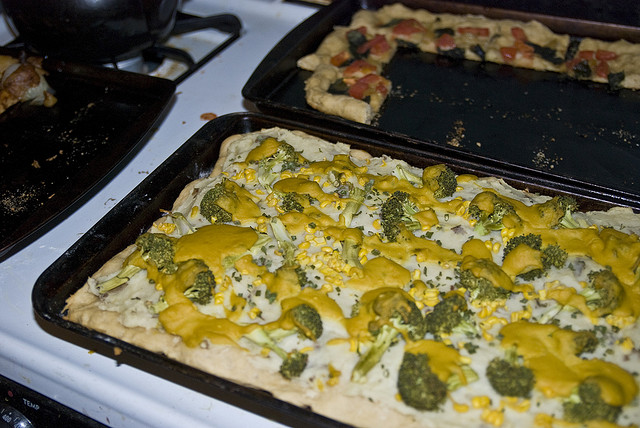

a baked good that has not been eaten yet ; it has broccoli on it


In [ ]:
print("INPUT")

# Get image and label from custom DataLoader
(imgs, prompts), outputs = next(iter(train_dataloader))
bboxes = torchvision.ops.box_convert(outputs, in_fmt='xywh', out_fmt='xyxy')

#convert the output image to pil to display the picture
tensor_to_pil = transforms.ToPILImage()
image_pil = tensor_to_pil(imgs[0])
image_pil.show()

#print(prompts)  #TODO domanda per Luca, perché prompts è una tupla?

referenceExpression = prompts[0]

print(referenceExpression)

## Step 2: find the bounding boxes inside the image with yolo

Get YOLO requirements

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -r yolov5/requirements.txt  # install
!mkdir -p /root/.cache/torch/hub/  #create the folder
!cp yolov5/requirements.txt /root/.cache/torch/hub/ #copy in the proper location

Import the YOLOv5 model

In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Execute the model to find the bounding boxes inside the input images.

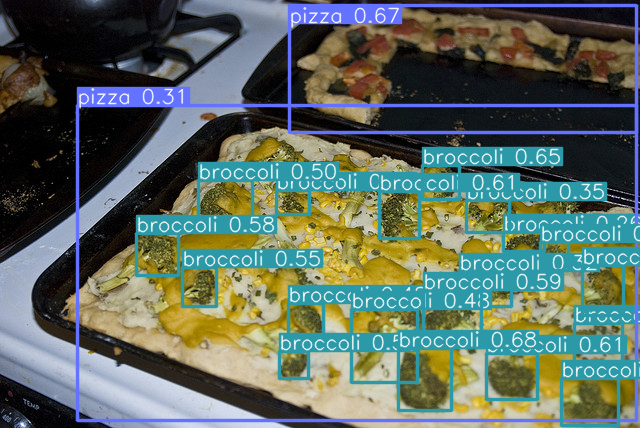

In [ ]:
#yolo inference
results = yolo_model(image_pil)
results.show()

## Step 3: compute the latent representation of the reference expression using clip

Load the CLIP model and set it to evaluation mode.

In [ ]:
clip_model, preprocess = clip.load("RN50")
clip_model = clip_model.cuda().eval()

Prepare input text tokens.

In [ ]:
texts = list()
texts.append(referenceExpression)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
type(text_tokens)

In [ ]:
text_tokens.shape

Execute the text encoder of CLIP to get the latent representation of the text tokens.

In [ ]:
with torch.no_grad():
  texts_z = clip_model.encode_text(text_tokens).float()

In [ ]:
texts_z.shape

## Step 4: for each bounding box: i. compute the representation of the crop in the latent space; ii. evaluate the similarity with the reference expression; Finally, consider only the bounding box with the higher similarity.

Get cropped images

In [ ]:
boundingBoxes = results.xyxy  #list

#boundingBoxes first image
img0_boundingBoxes = boundingBoxes[0] #torch.Size([num_bounding_boxes, 6])
                                      #xmin,ymin,xmax,ymax,confidence,class
                                      #274.06390,231.20389,392.66345,372.59018,0.93251,23.00000

cropped_images = list()
displayImages = list()
for bbox in img0_boundingBoxes:
  rectangle = (int(bbox[0]),  #x of the top left corner
               int(bbox[1]),  #y of the top left corner
               int(bbox[2]),  #x of the bottom right corner
               int(bbox[3])   #y of the bottom right corner
               )
  displayImages.append(image_pil.crop(rectangle))
  cropped_images.append(preprocess(image_pil.crop(rectangle)))

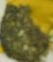

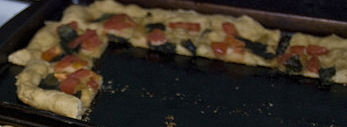

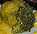

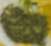

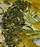

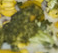

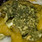

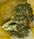

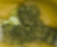

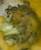

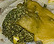

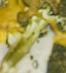

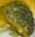

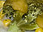

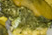

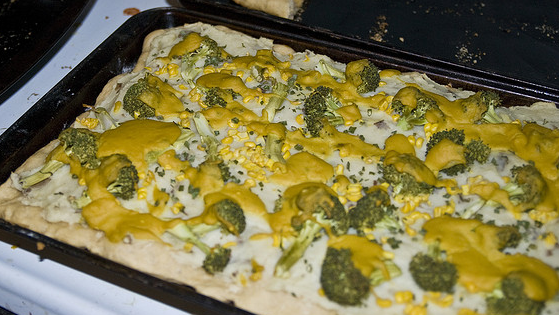

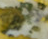

In [ ]:
for img in displayImages:
  img.show()

Compute the representation of the crops in the latent space.

In [ ]:
type(cropped_images[0]), cropped_images[0].shape

(torch.Tensor, torch.Size([3, 224, 224]))

In [ ]:
clip_input_images = torch.tensor(np.stack(cropped_images)).cuda()

In [ ]:
clip_input_images.shape

torch.Size([21, 3, 224, 224])

In [ ]:
with torch.no_grad():
    images_z = clip_model.encode_image(clip_input_images).float()

In [ ]:
images_z.shape

torch.Size([21, 1024])

Evaluate the cosine similarity between each bounding box and the reference expression. Finally, consider only the bounding box with the higher similarity score.

In [ ]:
with torch.no_grad():
  logits_per_image, logits_per_text = clip_model(clip_input_images, text_tokens)

In [ ]:
logits_per_text

tensor([[19.53125, 20.09375, 18.65625, 19.34375, 17.35938, 19.67188, 20.09375, 16.95312, 17.90625, 18.87500, 20.92188, 17.70312, 17.03125, 17.81250, 18.98438, 16.87500, 16.92188, 19.29688, 25.01562, 20.07812, 16.53125]], device='cuda:0', dtype=torch.float16)

Get index of the bounding box which is characterized by the highest similarity score with respect to the input reference expression.

In [ ]:
bestMatch = torch.argmax(logits_per_text)
bestBbox = img0_boundingBoxes[bestMatch]

r, g, b = torch.randint(0, 256, [3]).tolist()
img_bbox = torchvision.utils.draw_bounding_boxes(
    image=imgs[0],
    boxes=bestBbox[:4].unsqueeze(0),
    colors=(r, g, b),
    width=2,
)


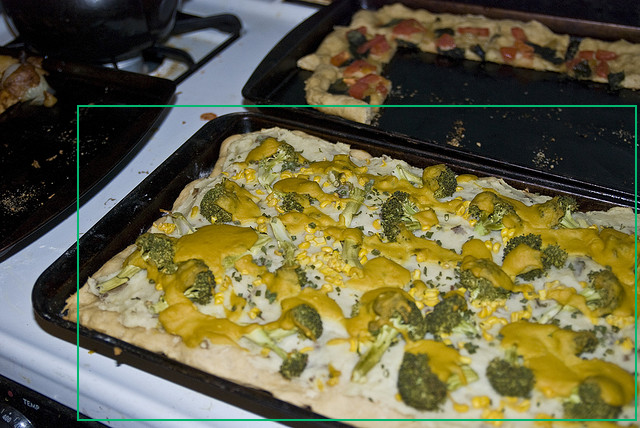

In [ ]:
output_pil = tensor_to_pil(img_bbox)
output_pil.show()

Output the groundtruth bounding box.

In [ ]:
bboxes #TODO domanda per luca, perché bboxes è una lista? non è sempre solo una la bounding box in output?

tensor([[ 60.59000, 124.07000, 638.63000, 423.19000]])

In [ ]:
img_bbox = torchvision.utils.draw_bounding_boxes(
    image=img_bbox,
    boxes=bboxes[0].unsqueeze(0),
    colors=(r, g, b),
    width=5,
)

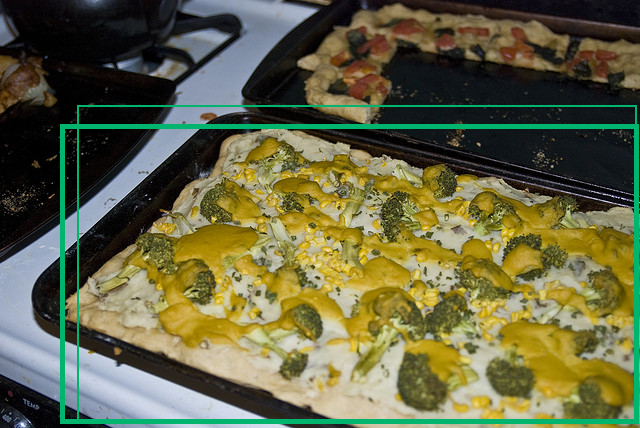

In [ ]:
output_pil = tensor_to_pil(img_bbox)
output_pil.show()

## Step 5: evaluate the results